## Calzada Jasso Andres Geovani *<span style = "color : Blue" > 23265539 </span>*

### *<span style = "color : #E3182E" >Práctica 2: Sensado y análisis de video</span>*

#### *<span style = "color : #01A9DB" >Detección de puntos de atención visual</span>*

En el curso de CDSI se realizó la siguiente práctica, en la cual se llevo a cabo la recolección de videos. 

El primer caso el cual consiste en la recolección de datos de video consta en colocar una cámara a la altura de los ojos. Donde se debe de alternar la mirada hacia: 1. Frente, 2. Izquierdo, 3. Derecho, 4. Retrovisor, 5. Palanca.

El segundo paso consta de la segmentación de los videos. Donde se deben de etoquetas los momentos de los PAV de los archivos de video de cada estudiante. Donde se debe de realizar una segmentación automática de cada video

El tercer paso el cual es la extracción y selección de características consta de extraer los landmarks de la cara en los videos utilizando modelos de seguimiento como MediaPipe u OpenPose, donde se debe de realizar un dataFrame con los landmarks extraídos en cada instancia.

El cuarto paso es la construcción y evaluación de modelos. En esta parte se debe de generar un modelo de detección de PAV's, utilizando los modelos de validación cruzada y analizar los videos mal clasificados.

El quinto paso consta de la validación externa, donde se debe de evaluar nuevos videos en tiempos reales para determinar el desempeño del detector de PAV's.

<img src="https://www.aao.org/image.axd?id=982789ad-2c7a-4d7e-acd7-87285e9c4a7d&t=636760073444630000">



# **<span style="color:#0000FF">1. Recolección de datos de audio</span>**

<div style=" font-style: italic;">

En esta sección del código se crea el diccionario d el cual tiene los PAV's y los valores de cada punto de atención visual son los tiempos en los que se enfoco la atención en estos puntos.
    
Posteriormente se crea un DataFrame a partir del diccionario d. Los puntos de atención visual se convierten en las columnas del DataFrame y los tiempos se convierten en las filas.
    
Por último la función de to_csv guarda el DataFrame en un archivo CSV con el nombre de ANDRES.csv en la carpeta indicada.
</div>

#### *<span style="color:red">Para fines prácticos este codigo estará comentado para que el archivo .csv no se este generando cada vez que el código de ejecute </span>*

In [ ]:

import pandas as pd
# Crear un diccionario con las clases y los valores
d = {
    "FRENTE": ["00:00 - 00:08", "00:14-00:16", "00:22-00:23", "00:29-00:36"],
    "RETROVISOR": ["00:24-00:28", "00:58-00:60", None, None],
    "IZQUIERDA": ["00:09- 00:13", "00:45-00:48", None, None],
    "DERECHA": ["00:17-00:21", "00:51-00:56", None, None],
    "PALANCA": ["00:37-00:43", None, None, None]
}

# Crear un dataframe con el diccionario
df = pd.DataFrame(d)

# Mostrar el dataframe
print(df)
df.to_csv("Videos/Crudos/ANDRES.csv")


# **<span style="color:#0000FF">2. Segmentación de videos </span>**

<div style=" font-style: italic;">

La segmentación de los videos correspondientes a los tiempos en los que sucede cada PAV se realiza en el siguiente apartado, donde se encarga de procesar el archivo .cvs y los videos correspondientes, se extraen y guardan segmentos segun las clases especificadas en el CSV. Para una mejor claridad vamos a realizar un análisis paso a paso de este código.
1. Configuración de logging: Limita los mensajes del paquete del moviepy a advertencias o errores

2. Funcion time_to_seconds: Convierte cadenas de tiempo con formarto hh:mm:ss o mm:ss a segundos para la segmebtación de los videos 

3. La función ensure_dir: verifica si existe un directorio y lo crea si es necesario
    
4. Diccionario directories: Establece directorios de salida para cada PAV
    
5. Creación de directorios: Verifica y crea los directorios para cada categoría.
    
6. Función process_file:

    -Lee el archivo CSV con pandas.
    
    -Itera por cada categoría identificada en el CSV.
    
    -Extrae los intervalos de tiempo para la categoría actual.
    
    -Convierte los intervalos a segundos (si no están vacíos).
    
    -Construye un nombre de archivo para el segmento con categoría y número de segmento.
    
    -Utiliza ffmpeg_extract_subclip (no incluido en el código) para extraer el segmento del video original y guardarlo en el directorio correspondiente.

7. Ruta de origen: Especifica el directorio principal con archivos CSV y videos.

8. Listado de archivos CSV: Encuentra todos los archivos CSV en el directorio de origen.

9.Procesamiento de archivos:

    -Itera por cada archivo CSV.
    
    -Construye la ruta del archivo CSV y la ruta del video correspondiente (agregando ".MP4").
    
    -Llama a la función process_file para ese archivo y video.


    En resumen este código nos permite extraer egmentos de video especificos basados información de clases y tiempos proporcionados en un archivo .CSV. Este código necesita la funcionalidad de ffmpeg_extract_subclip de una biblioteca externa para completar el proceso de extracción.
    

</div>

In [ ]:
import mediapipe as mp
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from moviepy.editor import VideoFileClip
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

In [ ]:
# Función para convertir tiempos en segundos
def time_to_seconds(time_str):
    if pd.isna(time_str):
        return []
    times = time_str.split('-')
    result = []
    for t in times:
        parts = t.strip().split(':')
        if len(parts) == 2:  # Solo minutos y segundos
            m, s = map(int, parts)
            result.append(m * 60 + s)
        elif len(parts) == 3:  # Horas, minutos y segundos
            h, m, s = map(int, parts)
            result.append(h * 3600 + m * 60 + s)
        else:
            return []
    return result

# Función para asegurar la existencia del directorio
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Directorios para cada categoría
directories = {
    'FRENTE': './Videos/Frente',
    'DERECHA': './Videos/Derecha',
    'IZQUIERDA': './Videos/Izquierda',
    'PALANCA': './Videos/Palanca',
    'RETROVISOR': './Videos/Retrovisor',
}

# Asegurar la existencia de los directorios
for directory in directories.values():
    ensure_dir(directory)

# Función para procesar un archivo .csv y su video correspondiente
def process_file(csv_file_path, video_file_path):
    df = pd.read_csv(csv_file_path)
    for category, directory in directories.items():
        segments = []
        for time_range in df[category]:
            if pd.notna(time_range):
                start_end = time_to_seconds(time_range)
                if start_end:
                    segments.append(start_end)
        for i, (start, end) in enumerate(segments):
            output_path = os.path.join(directory, f'{os.path.splitext(os.path.basename(csv_file_path))[0]}{category}_segment{i+1}.mp4')
            ffmpeg_extract_subclip(video_file_path, start, end, targetname=output_path)

# Directorio donde están los archivos .csv y los videos
source_directory = './Videos/Crudos/'

# Listar todos los archivos .csv en el directorio
csv_files = [f for f in os.listdir(source_directory) if f.endswith('.csv')]

# Procesar cada archivo .csv y su video correspondiente
for csv_file in csv_files:
    csv_file_path = os.path.join(source_directory, csv_file)
    video_file_path = os.path.join(source_directory, os.path.splitext(csv_file)[0] + '.MP4')
    process_file(csv_file_path, video_file_path)


# **<span style="color:#0000FF">3. Extracción y selección de características</span>**

<div style=" font-style: italic;">
1. Inicialización de la detección de rostros:

    -Carga la solución de detección de rostros de MediaPipe.
    
    -Crea un objeto FaceDetection con un modelo específico y un umbral de confianza mínimo
    
2. Función para procesar un video:

*Toma como entrada la ruta del video y una lista vacía para almacenar las detecciones.
    
*Abre el video con OpenCV.
    
*Recorre cada cuadro del video:
    
        -Convierte el cuadro a formato RGB (requerido por MediaPipe).
    
        -Aplica la detección de rostros al cuadro.
    
        -Si se encuentran rostros:
    
            +Para cada rostro detectado:
    
                #Obtiene el cuadro delimitador relativo (bounding box) del rostro.
    
                #Extrae los puntos clave (landmarks) relativos del rostro.
    
                #Crea un diccionario con la información de la detección:
    
                    -Nombre del video.
    
                    -Coordenadas del cuadro delimitador.
    
                    -Coordenadas de los puntos clave.
    
                #Agrega el diccionario a la lista de detecciones.
    
*Cierra el video.
    
    
    En resumen, el código procesa un video, detecta rostros en cada cuadro y almacena la información de los rostros detectados (cuadro delimitador y puntos clave) en una lista.

</div>

In [ ]:
# Inicializar MediaPipe Face Detection
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)


# Función para procesar un único video
def process_video(video_path, all_detections):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error al cargar el video {video_path}.")
        return
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_detection.process(frame_rgb)

        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                xmin = bboxC.xmin
                ymin = bboxC.ymin
                width = bboxC.width
                height = bboxC.height

                landmarks_relative = {}
                keypoints = detection.location_data.relative_keypoints

                for i, keypoint in enumerate(keypoints):
                    relative_x = keypoint.x
                    relative_y = keypoint.y

                    landmarks_relative[f"landmark_{i}_x"] = relative_x
                    landmarks_relative[f"landmark_{i}_y"] = relative_y
                
                detection_data = {
                    "video_name": os.path.basename(video_path),
                    "xmin": xmin,
                    "ymin": ymin,
                    "width": width,
                    "height": height,
                }
                
                detection_data.update(landmarks_relative)
                all_detections.append(detection_data)

    cap.release()


#### *<span style = "color : #01A9DB" >Para los videos segmentados correspondientes a la carpeta de "Derecha"</span>*

1. Directorio de videos:
    * Se define el directorio que contiene los videos que se procesarán 
2. Lista para almacenar detecciones:
    * Se creauna lista vacía para almacenar la información de las detecciones de todos los videos 
3. Bucle para procesar los videos:
    * Se recorre cada archivo en el directorio especificado 
    * Si el archivo es un video (.mp4)
    
        #Se llama a la función process_video con la ruta del archivo y la lista de detecciones

4. Almacenamiento de datos:
    * Se crea un DataFrame de pandas con la información de todas las detecciones acumuladas 
    * Se guarda el DataFrame en un archivo .csv con el nombre de "landmark_Derecha.cvs" en el mismo directorio que los videos 

5. Mensaje final:
    * Se muestra un mensaje con la ruta del archivo CSV donde se han almacenado todas las detecciones y puntos de referenci relativos.
    
Resumen 

El código procesa todos los videos dentro del directorio especificado, detecta rostros en cada uno y guarda la información de las detecciones (coordenadas del cuadro delimitador y puntos clave) en un único archivo CSV

Es importante mencionar que el código depende de la función process_video que se ha explicado en la celda anterior.
        

In [ ]:
# Directorio que contiene los videos
video_dir = "Videos/Derecha"
all_detections = []

# Procesar cada video en el directorio y acumular los resultados
for video_file in os.listdir(video_dir):
    video_path = os.path.join(video_dir, video_file)
    if os.path.isfile(video_path) and video_path.endswith('.mp4'):
        process_video(video_path, all_detections)




# Guardar todos los datos acumulados en un único archivo CSV
csv_filename = os.path.join(video_dir, "landmarks_Derecha.csv")
df = pd.DataFrame(all_detections)

# Agrega el nombre de la clase la cual se quiere agregar al archivo final de .csv
class_name = "Derecha"  
df['class'] = class_name   

df.to_csv(csv_filename, index=False)
print(f"Todas las detecciones y puntos de referencia relativos de todos los videos se almacenan en: {csv_filename}")


#### *<span style = "color : #01A9DB" >Para los videos segmentados correspondientes a la carpeta de "Frente"</span>*

1. Directorio de videos:
    * Se define el directorio que contiene los videos que se procesarán 
2. Lista para almacenar detecciones:
    * Se creauna lista vacía para almacenar la información de las detecciones de todos los videos 
3. Bucle para procesar los videos:
    * Se recorre cada archivo en el directorio especificado 
    * Si el archivo es un video (.mp4)
    
        #Se llama a la función process_video con la ruta del archivo y la lista de detecciones

4. Almacenamiento de datos:
    * Se crea un DataFrame de pandas con la información de todas las detecciones acumuladas 
    * Se guarda el DataFrame en un archivo .csv con el nombre de "landmark_Frente.cvs" en el mismo directorio que los videos 

5. Mensaje final:
    * Se muestra un mensaje con la ruta del archivo CSV donde se han almacenado todas las detecciones y puntos de referenci relativos.
    
Resumen 

El código procesa todos los videos dentro del directorio especificado, detecta rostros en cada uno y guarda la información de las detecciones (coordenadas del cuadro delimitador y puntos clave) en un único archivo CSV

Es importante mencionar que el código depende de la función process_video que se ha explicado en la celda anterior.

In [ ]:
# Directorio que contiene los videos
video_dir = "Videos/Frente"
all_detections = []

# Procesar cada video en el directorio y acumular los resultados
for video_file in os.listdir(video_dir):
    video_path = os.path.join(video_dir, video_file)
    if os.path.isfile(video_path) and video_path.endswith('.mp4'):
        process_video(video_path, all_detections)

# Guardar todos los datos acumulados en un único archivo CSV
csv_filename = os.path.join(video_dir, "landmarks_Frente.csv")
df = pd.DataFrame(all_detections)

# Agrega el nombre de la clase la cual se quiere agregar al archivo final de .csv
class_name = "Frente"  
df['class'] = class_name   

df.to_csv(csv_filename, index=False)
print(f"Todas las detecciones y puntos de referencia relativos de todos los videos se almacenan en: {csv_filename}")


#### *<span style = "color : #01A9DB" >Para los videos segmentados correspondientes a la carpeta de "Izquierda"</span>*

1. Directorio de videos:
    * Se define el directorio que contiene los videos que se procesarán 
2. Lista para almacenar detecciones:
    * Se creauna lista vacía para almacenar la información de las detecciones de todos los videos 
3. Bucle para procesar los videos:
    * Se recorre cada archivo en el directorio especificado 
    * Si el archivo es un video (.mp4)
    
        #Se llama a la función process_video con la ruta del archivo y la lista de detecciones

4. Almacenamiento de datos:
    * Se crea un DataFrame de pandas con la información de todas las detecciones acumuladas 
    * Se guarda el DataFrame en un archivo .csv con el nombre de "landmark_Izquierda.cvs" en el mismo directorio que los videos 

5. Mensaje final:
    * Se muestra un mensaje con la ruta del archivo CSV donde se han almacenado todas las detecciones y puntos de referenci relativos.
    
Resumen 

El código procesa todos los videos dentro del directorio especificado, detecta rostros en cada uno y guarda la información de las detecciones (coordenadas del cuadro delimitador y puntos clave) en un único archivo CSV

Es importante mencionar que el código depende de la función process_video que se ha explicado en la celda anterior.

In [ ]:
# Directorio que contiene los videos
video_dir = "Videos/Izquierda"
all_detections = []

# Procesar cada video en el directorio y acumular los resultados
for video_file in os.listdir(video_dir):
    video_path = os.path.join(video_dir, video_file)
    if os.path.isfile(video_path) and video_path.endswith('.mp4'):
        process_video(video_path, all_detections)

# Guardar todos los datos acumulados en un único archivo CSV
csv_filename = os.path.join(video_dir, "landmarks_Izquierda.csv")
df = pd.DataFrame(all_detections)

# Agrega el nombre de la clase la cual se quiere agregar al archivo final de .csv
class_name = "Izquierda"  
df['class'] = class_name   

df.to_csv(csv_filename, index=False)
print(f"Todas las detecciones y puntos de referencia relativos de todos los videos se almacenan en: {csv_filename}")


#### *<span style = "color : #01A9DB" >Para los videos segmentados correspondientes a la carpeta de "Palanca"</span>*

1. Directorio de videos:
    * Se define el directorio que contiene los videos que se procesarán 
2. Lista para almacenar detecciones:
    * Se creauna lista vacía para almacenar la información de las detecciones de todos los videos 
3. Bucle para procesar los videos:
    * Se recorre cada archivo en el directorio especificado 
    * Si el archivo es un video (.mp4)
    
        #Se llama a la función process_video con la ruta del archivo y la lista de detecciones

4. Almacenamiento de datos:
    * Se crea un DataFrame de pandas con la información de todas las detecciones acumuladas 
    * Se guarda el DataFrame en un archivo .csv con el nombre de "landmark_Palanca.cvs" en el mismo directorio que los videos 

5. Mensaje final:
    * Se muestra un mensaje con la ruta del archivo CSV donde se han almacenado todas las detecciones y puntos de referenci relativos.
    
Resumen 

El código procesa todos los videos dentro del directorio especificado, detecta rostros en cada uno y guarda la información de las detecciones (coordenadas del cuadro delimitador y puntos clave) en un único archivo CSV

Es importante mencionar que el código depende de la función process_video que se ha explicado en la celda anterior.

In [ ]:
# Directorio que contiene los videos
video_dir = "Videos/Palanca"
all_detections = []

# Procesar cada video en el directorio y acumular los resultados
for video_file in os.listdir(video_dir):
    video_path = os.path.join(video_dir, video_file)
    if os.path.isfile(video_path) and video_path.endswith('.mp4'):
        process_video(video_path, all_detections)

# Guardar todos los datos acumulados en un único archivo CSV
csv_filename = os.path.join(video_dir, "landmarks_Palanca.csv")
df = pd.DataFrame(all_detections)

# Agrega el nombre de la clase la cual se quiere agregar al archivo final de .csv
class_name = "Palanca"  
df['class'] = class_name   

df.to_csv(csv_filename, index=False)
print(f"Todas las detecciones y puntos de referencia relativos de todos los videos se almacenan en: {csv_filename}")


#### *<span style = "color : #01A9DB" >Para los videos segmentados correspondientes a la carpeta de "Retrovisor"</span>*

1. Directorio de videos:
    * Se define el directorio que contiene los videos que se procesarán 
2. Lista para almacenar detecciones:
    * Se creauna lista vacía para almacenar la información de las detecciones de todos los videos 
3. Bucle para procesar los videos:
    * Se recorre cada archivo en el directorio especificado 
    * Si el archivo es un video (.mp4)
    
        #Se llama a la función process_video con la ruta del archivo y la lista de detecciones

4. Almacenamiento de datos:
    * Se crea un DataFrame de pandas con la información de todas las detecciones acumuladas 
    * Se guarda el DataFrame en un archivo .csv con el nombre de "landmark_Retrovisor.cvs" en el mismo directorio que los videos 

5. Mensaje final:
    * Se muestra un mensaje con la ruta del archivo CSV donde se han almacenado todas las detecciones y puntos de referenci relativos.
    
Resumen 

El código procesa todos los videos dentro del directorio especificado, detecta rostros en cada uno y guarda la información de las detecciones (coordenadas del cuadro delimitador y puntos clave) en un único archivo CSV

Es importante mencionar que el código depende de la función process_video que se ha explicado en la celda anterior.

In [ ]:
# Directorio que contiene los videos
video_dir = "Videos/Retrovisor"
all_detections = []

# Procesar cada video en el directorio y acumular los resultados
for video_file in os.listdir(video_dir):
    video_path = os.path.join(video_dir, video_file)
    if os.path.isfile(video_path) and video_path.endswith('.mp4'):
        process_video(video_path, all_detections)

# Guardar todos los datos acumulados en un único archivo CSV
csv_filename = os.path.join(video_dir, "landmarks_Retrovisor.csv")
df = pd.DataFrame(all_detections)

# Agrega el nombre de la clase la cual se quiere agregar al archivo final de .csv
class_name = "Retrovisor"  
df['class'] = class_name   

df.to_csv(csv_filename, index=False)
print(f"Todas las detecciones y puntos de referencia relativos de todos los videos se almacenan en: {csv_filename}")


# **<span style="color:#0000FF">4. Construcción y Evaluación de modelos</span>**

En esta sección vamos a trabajar la parte de la construcción de los modelos, para esto una vez que los archivos .csv ya se generaron de manera automática correspondiente a los "landmarks" de cada PAV los vamos a cargar y trabajar con ellos. 

Cabe mencionar que estos archivos .csv tienes las carcaterísticas que vamos a usar para hacer el entrenamiento de los modelos, los archivos .csv que se generaron durante la extracción de las características fueron los siguientes:
* landmarks_Derecha.csv
* landmarks_Frente.csv
* landmarks_Izquierda.csv
* landmarks_Palanca.csv
* landmarks_Retrovisor.csv

Cada uno de archivos .cvs tiene todos los landmark's extraidos de los videos segmentados, donde la clase de cada archivo .csv es el PAV del cual se le extrajeron las características.

In [ ]:
import pandas as pd 


In [ ]:
#Vamos a proceder a cargar el archivo .csv correspondiente a landmarks_Derecha.csv
df_derecha = pd.read_csv('Videos/Derecha/landmarks_Derecha.csv')
df_derecha.head()

In [ ]:
#Vamos a proceder a cargar el archivo .csv correspondiente a landmarks_Frente.csv
df_frente = pd.read_csv('Videos/Frente/landmarks_Frente.csv')
df_frente.head()

In [ ]:
#Vamos a proceder a cargar el archivo .csv correspondiente a landmarks_Izquierda.csv
df_izquierda = pd.read_csv('Videos/Izquierda/landmarks_Izquierda.csv')
df_izquierda.head()

In [ ]:
#Vamos a proceder a cargar el archivo .csv correspondiente a landmarks_Palanca.csv
df_palanca = pd.read_csv('Videos/Palanca/landmarks_Palanca.csv')
df_palanca.head()

In [ ]:
#Vamos a proceder a cargar el archivo .csv correspondiente a landmarks_Retrovisor.csv
df_retrovisor = pd.read_csv('Videos/Retrovisor/landmarks_Retrovisor.csv')
df_retrovisor.head()

#### <span style="color:red">Observación</span> 

Prestando atención a los DataFrames extraidos de los archivos .csv que se obtuvieron de todos los landmark's son DataFrame's independientes por lo que vamos a proceder a concatenar todos los landmark's para hacer uno total y de ahí comenzar con el análisis exploratorio.

In [ ]:
# Concatenar los DataFrames
df = pd.concat([df_retrovisor, df_palanca, df_izquierda, df_frente, df_derecha], ignore_index=True)
# Vamos a proceder a guardar el archivo en un .csv total para poder trabajar con esas características y entrenar los modelos
df.to_csv('FULL.csv')

#### <span style="color:red">Observación 1</span>

Una vez que ya tenemos el archivo .csv completo con todas las clases o PAV indicados, vamos a proceder a leer este archivo con la libreria de pandas para comenzar con nuestro análisis exploratorio, para comenzar con el entrenamiento de los modelos.

Cargamos el archivo .csv con todas la clases 

# **<span style="color:red">Correr el scrip a partir de este momento</span>**

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import mutual_info_classif

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import LabelEncoder

In [2]:
#Comenzamos leyendo nuestro archivo .csv donde tenemos todas nuestras features y clases juntas 
df = pd.read_csv('FULL.csv')
df.head()

,Unnamed: 0,video_name,xmin,ymin,width,height,landmark_0_x,landmark_0_y,landmark_1_x,landmark_1_y,landmark_2_x,landmark_2_y,landmark_3_x,landmark_3_y,landmark_4_x,landmark_4_y,landmark_5_x,landmark_5_y,class
0,0,ANDRESRETROVISOR_segment1.mp4,0.263215,0.362846,0.349267,0.197650,0.366920,0.425277,0.511518,0.423857,0.428224,0.465318,0.432839,0.503788,0.309365,0.448271,0.613918,0.446762,Retrovisor
1,1,ANDRESRETROVISOR_segment1.mp4,0.262060,0.364248,0.340342,0.192572,0.361236,0.423529,0.505577,0.422115,0.416569,0.458088,0.421138,0.498809,0.306025,0.448922,0.614924,0.448435,Retrovisor
2,2,ANDRESRETROVISOR_segment1.mp4,0.250039,0.354061,0.350128,0.198172,0.354193,0.418969,0.496626,0.416840,0.410802,0.458204,0.414705,0.496870,0.300112,0.441435,0.600933,0.438784,Retrovisor
3,3,ANDRESRETROVISOR_segment1.mp4,0.243997,0.354059,0.352781,0.199663,0.351108,0.418853,0.491792,0.417864,0.403855,0.459850,0.407766,0.498198,0.298379,0.442049,0.598347,0.442876,Retrovisor
4,4,ANDRESRETROVISOR_segment1.mp4,0.241638,0.354374,0.348102,0.196986,0.345526,0.417454,0.483071,0.415736,0.392883,0.459438,0.402375,0.496799,0.309093,0.438114,0.600009,0.438568,Retrovisor


In [3]:
# Eliminamos las columnas que no son necesarias para el entrenamiento, en este la caso los features que no nos proporcionan información relevante son
# Unnamed:0 la cual es una columna creada para solamente enumerar los datos
# video_name el cual solamente nos indica el nombre de los videos a los cuales corresponde 
df = df.drop(['Unnamed: 0', 'video_name'], axis=1)

In [4]:
#Imprimimos la información del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10189 entries, 0 to 10188
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   xmin          10189 non-null  float64
 1   ymin          10189 non-null  float64
 2   width         10189 non-null  float64
 3   height        10189 non-null  float64
 4   landmark_0_x  10189 non-null  float64
 5   landmark_0_y  10189 non-null  float64
 6   landmark_1_x  10189 non-null  float64
 7   landmark_1_y  10189 non-null  float64
 8   landmark_2_x  10189 non-null  float64
 9   landmark_2_y  10189 non-null  float64
 10  landmark_3_x  10189 non-null  float64
 11  landmark_3_y  10189 non-null  float64
 12  landmark_4_x  10189 non-null  float64
 13  landmark_4_y  10189 non-null  float64
 14  landmark_5_x  10189 non-null  float64
 15  landmark_5_y  10189 non-null  float64
 16  class         10189 non-null  object 
dtypes: float64(16), object(1)
memory usage: 1.3+ MB


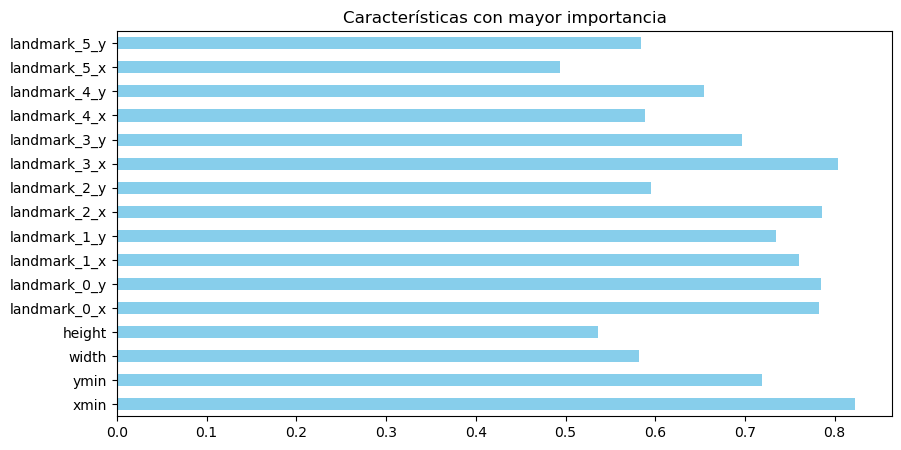

In [5]:
#Observamos la ganancia de información de cada atributo con respecto a la clase
x_nueva = mutual_info_classif(df.iloc[:,0:-1], df.iloc[:,-1])
feat_imp = pd.Series(x_nueva, df.columns[0:len(df.columns)-1])
fig, ax = plt.subplots(figsize=(10, 5))
# Crea el gráfico de barras horizontales
feat_imp.plot(ax=ax, title="Características con mayor importancia", kind='barh', color = 'skyblue')
plt.show()

El siguiente paso que vamos a realizar, sera cambiar nuestro tipo de clases, ya que en este caso las clases en nuestro DataFrame son: 
* Retrovisor
* Palanca
* Izquierda
* Frente
* Derecha

Las cuales al aplicar LabelEncoder quedaran de la siguiente manera:
* Retrovisor --> 4 
* Palanca --> 3
* Izquierda --> 2
* Frente --> 1
* Derecha --> 0

In [6]:
#Creamos una instancia de LabelEncoder
label_encoder = LabelEncoder()
#Ajustamos el LabelEncoder a las etoquetas únicas de la columna "class"
label_encoder.fit(df['class'])
#Tranformamos las etiquetas de clase en número y crea una nueva columna 'clase' en el DataFrame
df['clase'] = label_encoder.transform(df['class'])

In [7]:
df.info

<bound method DataFrame.info of            xmin      ymin     width    height  landmark_0_x  landmark_0_y  \
0      0.263215  0.362846  0.349267  0.197650      0.366920      0.425277   
1      0.262060  0.364248  0.340342  0.192572      0.361236      0.423529   
2      0.250039  0.354061  0.350128  0.198172      0.354193      0.418969   
3      0.243997  0.354059  0.352781  0.199663      0.351108      0.418853   
4      0.241638  0.354374  0.348102  0.196986      0.345526      0.417454   
...         ...       ...       ...       ...           ...           ...   
10184 -0.023204  0.382439  0.540473  0.303944      0.174090      0.479785   
10185 -0.022476  0.382838  0.539069  0.303157      0.174614      0.480405   
10186 -0.013772  0.384852  0.535694  0.301241      0.179742      0.480320   
10187 -0.013590  0.384802  0.535830  0.301318      0.179651      0.480127   
10188 -0.014092  0.384201  0.536286  0.301576      0.178556      0.479066   

       landmark_1_x  landmark_1_y  landmark

In [8]:
# Dividimos nuestros datos en features 
X = df.iloc[:,0:-2]
X.info

<bound method DataFrame.info of            xmin      ymin     width    height  landmark_0_x  landmark_0_y  \
0      0.263215  0.362846  0.349267  0.197650      0.366920      0.425277   
1      0.262060  0.364248  0.340342  0.192572      0.361236      0.423529   
2      0.250039  0.354061  0.350128  0.198172      0.354193      0.418969   
3      0.243997  0.354059  0.352781  0.199663      0.351108      0.418853   
4      0.241638  0.354374  0.348102  0.196986      0.345526      0.417454   
...         ...       ...       ...       ...           ...           ...   
10184 -0.023204  0.382439  0.540473  0.303944      0.174090      0.479785   
10185 -0.022476  0.382838  0.539069  0.303157      0.174614      0.480405   
10186 -0.013772  0.384852  0.535694  0.301241      0.179742      0.480320   
10187 -0.013590  0.384802  0.535830  0.301318      0.179651      0.480127   
10188 -0.014092  0.384201  0.536286  0.301576      0.178556      0.479066   

       landmark_1_x  landmark_1_y  landmark

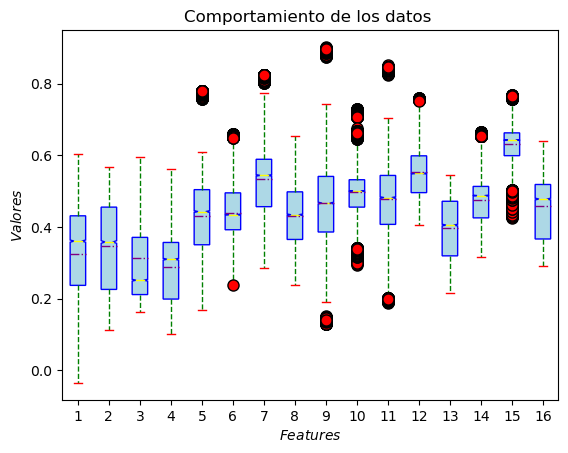

In [9]:
#Como podemos observra el comportamiento de los datos nos indica que no estan muy dispersos cada uno
#Esto quiere decir que el modelo puede aprender con mayor precisión
# Crear la gráfica de caja
plt.boxplot(X,notch=True, patch_artist=True,
            whiskerprops={'color':'green', 'linestyle':'--'},
            boxprops={'color':'blue', 'facecolor':'lightblue'},
            capprops={'color':'red'},
            medianprops={'color':'yellow'},
            flierprops={'marker':'o', 'markerfacecolor':'red', 'markersize':8},
            showmeans=True, meanline=True,
            meanprops={'color':'purple', 'linestyle':'-.'} )

# Añadir títulos y etiquetas (opcional)
plt.title('Comportamiento de los datos ')
plt.ylabel('$Valores$')
plt.xlabel('$Features$')

# Mostrar la gráfica
plt.show()

In [10]:
#Dividimos nuestros datos en la clase
Y = df.iloc[:,-1]
Y.info

<bound method Series.info of 0        4
1        4
2        4
3        4
4        4
        ..
10184    0
10185    0
10186    0
10187    0
10188    0
Name: clase, Length: 10189, dtype: int32>

#### **Aplicamos reducción de dimensionalidad**

Aplicamos reducción de dimensionalidad para observar como se comportan los datos y tener idea de que tipo de modelo podemos ocupar 

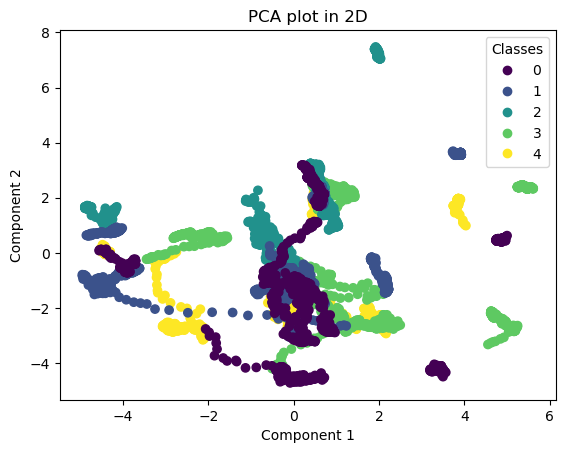

In [11]:
# Es una buena práctica estandarizar las características antes de aplicar PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Aplicar PCA para reducir a 2 componentes
pca = PCA(n_components=2)
X_PCA = pca.fit_transform(X_scaled)

# Visualizar los resultados
scatter = plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=Y.values.ravel())
plt.title('PCA plot in 2D')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

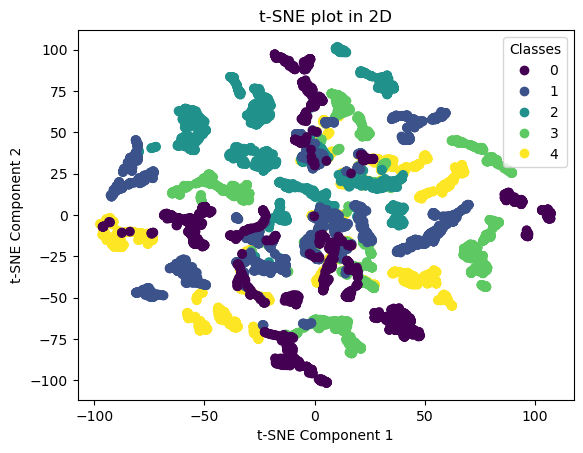

In [12]:
# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar t-SNE para reducir a 2 componentes
tsne = TSNE(n_components=2, random_state=42)
X_TSNE = tsne.fit_transform(X_scaled)

# Visualizar los resultados
scatter = plt.scatter(X_TSNE[:, 0], X_TSNE[:, 1], c=Y.values.ravel())
plt.title('t-SNE plot in 2D')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

#### **<span style="color:purple">Aquí es donde me empiezo a preocupar</span>**

Debido a que al realizar reducción de dimensionalidad se observa que mis clases siguen estando juntas.

<img src="https://www.petlife.mx/u/fotografias/m/2023/8/27/f768x1-5662_5789_119.jpg">



### **<span style="color:green">Comenzamos con los clasificadores</span>.**

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [14]:
#Dividimos nuestro DataFrame en conjuntos para entrenamiento y para prueba
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7641, 16), (7641,), (2548, 16), (2548,))

#### **<span style="color:purple">Árboles de decisión</span>.**

In [15]:
clf1 = DecisionTreeClassifier()
clf1 = clf1.fit(x_train, y_train)
y_pred = clf1.predict(x_test)
print("Decision tree score: {:.3f}".format(accuracy_score(y_test, y_pred)))

#Realizamos la predicción por medio de la validación cruzada con k=10
y_pred = cross_val_predict(clf1, x_train, y_train, cv=10)

cm = confusion_matrix(y_train, y_pred) 
print ("Confusion Matrix : \n", cm) 

Decision tree score: 0.937
Confusion Matrix : 
 [[1390   49    5   20   47]
 [  41 1677   23   41   47]
 [   8   29 1424   12   32]
 [  17   31   19 1263   24]
 [  53   39   30   33 1287]]


#### **<span style="color:purple">Naive Bayes</span>.**

In [16]:
clasificador2 = GaussianNB()

#Realizamos la predicción por medio de la validación cruzada con k=10
y_pred = cross_val_predict(clasificador2, x_train, y_train, cv=10)

cm = confusion_matrix(y_train, y_pred) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_train, y_pred))

Confusion Matrix : 
 [[583 313 256 160 199]
 [ 17 621 467 270 454]
 [  0 415 963   0 127]
 [ 69 382 124 678 101]
 [102 472  71 369 428]]
Test accuracy =  0.42834707499018454


#### **<span style="color:purple">Random Forest</span>.**

In [17]:
clf3 = RandomForestClassifier()
clf3 = clf3.fit(x_train, y_train)
y_pred = clf3.predict(x_test)
print("Random Forest score: {:.3f}".format(accuracy_score(y_test,y_pred)))

Random Forest score: 0.963


#### **<span style="color:purple">Neural Net</span>.**

In [18]:
clasificador4 = MLPClassifier(alpha=1, max_iter=1000, random_state=42)
#Realizamos la predicción por medio de la validación cruzada con k=10
y_pred = cross_val_predict(clasificador4, x_train, y_train, cv=10)
cm = confusion_matrix(y_train, y_pred) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_train, y_pred))

Confusion Matrix : 
 [[ 815  131  274    0  291]
 [  36 1418  317   14   44]
 [ 158  202 1055    0   90]
 [ 143  193  124  828   66]
 [ 255   95  108  152  832]]
Test accuracy =  0.6475592199973825


#### **<span style="color:purple">SVM</span>.**

In [19]:
clasificador5 = SVC(gamma=2, C=1, random_state=42)
#Realizamos la predicción por medio de la validación cruzada con k=10
y_pred = cross_val_predict(clasificador5, x_train, y_train, cv=10)
cm = confusion_matrix(y_train, y_pred) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_train, y_pred))


Confusion Matrix : 
 [[1215  142   17    0  137]
 [  40 1625   13   15  136]
 [  14  113 1099    2  277]
 [ 130   74    7 1012  131]
 [ 131  107   23   12 1169]]
Test accuracy =  0.800942285041225


### **<span style="color:orange">Comparamos con MetaModelos</span>.**

In [20]:
#Método de validación
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score #Conocer la precisión de nuestros modelos 
from numpy import mean #Conocer la media o promedio de los 5 conjuntos 

In [21]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

#### **<span style="color:purple">Árboles de decisión</span>.**

In [22]:
clf_ddt = DecisionTreeClassifier()
scores = []

for train_index, test_index in sss.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    clf_ddt.fit(X_train, y_train)
    y_pred = clf_ddt.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='weighted'))

print(scores)
print(mean(scores))


[0.9279280061851939, 0.938665955768163, 0.9219505838428971, 0.9267118311757075, 0.9420532246645245]
0.9314619203272972


#### **<span style="color:purple">Naive Bayes</span>.**

In [23]:
clf_nb = GaussianNB()
scores = []

for train_index, test_index in sss.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    clf_nb.fit(X_train, y_train)
    y_pred = clf_nb.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='weighted'))

print(scores)
print(mean(scores))

[0.4352481765938546, 0.4425024763171764, 0.4305168835051235, 0.41850540475884584, 0.40935635212841126]
0.42722585866068236


## Resultados con clasificadores y Metamodelos 

#### **<span style="color:red">Clasificadores</span>.**

|Clasificador | Score |
|----------|----------|
| Arboles de Desición   | 0.91   |
|Naive Bayes     | 0.57 |
|Neural Net| 0.69 |
|SVM| 0.81|
|Random Forest| 0.96 |

#### **<span style="color:red">Metamodelos</span>.**

|Clasificador | Precision |
|----------|----------|
| Arboles de decisión   | 0.91   |
| Naive Bayes     | 0.56 |

En este análisis de clasificadores, los Árboles de Decisión emergen como la opción más efectiva con un destacado score de 0.91, tanto individualmente como en un metamodelo. En contraste, Naive Bayes presenta un rendimiento inferior, evidenciado por su score de 0.57, y esta tendencia se mantiene en el metamodelo. Las Redes Neuronales, con un score de 0.69, podrían beneficiarse de ajustes adicionales en hiperparámetros o arquitecturas más complejas. Por otro lado, las Máquinas de Soporte Vectorial (SVM) muestran solidez con un score de 0.81. La precisión del metamodelo refleja en gran medida el rendimiento de los clasificadores individuales, indicando que, en algunos casos, la combinación de modelos no necesariamente mejora la precisión. 



# **<span style="color:#0000FF">5. Validación Externa</span>**


In [24]:
df = pd.read_csv('FULL.csv')


In [25]:
X = df.iloc[:, 2:-1]


In [26]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.simplefilter("ignore")

# Inicializar MediaPipe para la detección de rostros
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
clfF = DecisionTreeClassifier()
clfF.fit(X, Y)
def extract_features(detection, image_width, image_height):
    bboxC = detection.location_data.relative_bounding_box
    xmin = bboxC.xmin * image_width
    ymin = bboxC.ymin * image_height
    width = bboxC.width * image_width
    height = bboxC.height * image_height

    landmarks_relative = []
    keypoints = detection.location_data.relative_keypoints
    for keypoint in keypoints:
        relative_x = keypoint.x * image_width
        relative_y = keypoint.y * image_height
        landmarks_relative.extend([relative_x, relative_y])

    detection_data = [xmin, ymin, width, height] + landmarks_relative
    return detection_data

cap = cv2.VideoCapture(0)
with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            continue

        image_height, image_width, _ = image.shape
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_rgb.flags.writeable = False
        results = face_detection.process(image_rgb)

        image_rgb.flags.writeable = True
        image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

        if results.detections:
            for detection in results.detections:
                features = extract_features(detection, image_width, image_height)
                features_array = np.array(features).reshape(1, -1)

                if features_array.shape[1] == X.shape[1]:
                    prediction = clfF.predict(features_array)
                    label = f"Clase: {prediction[0]}"
                else:
                    label = "Incompatible feature set"

                # Obtener las coordenadas del cuadro delimitador para colocar el texto de manera dinámica
                bboxC = detection.location_data.relative_bounding_box
                x = int(bboxC.xmin * image_width)
                y = int(bboxC.ymin * image_height)

                mp_drawing.draw_detection(image, detection)
                # Colocar el texto justo encima del cuadro delimitador de la detección
                cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow('Face Detection and Classification', image)
        if cv2.waitKey(5) != -1:
            break

cap.release()
cv2.destroyAllWindows()


# **<span style="color:#0000FF">5. Validación Externa (Intento con videos externos)</span>**

Dado que al hacer la validación externa con Live Recognition, vamos a realizar un nuevo intento de validación, la cual consistio en:

1. Grabar las 5 clases de los videos por aparte 
2. Realizar el reconocimiento de patrones y guardarlo en .csv's correspondientes 
3. Leer los archivos generados para conocer si nuestro modelo aprendio de manera correcta con nuestros datos 

In [27]:
df_Derecha = pd.read_csv('Prueba_Derecha.csv')
df_Izquierda = pd.read_csv('Prueba_Izquierda.csv')
df_Frente = pd.read_csv('Prueba_Frente.csv')
df_Palanca = pd.read_csv('Prueba_Palanca.csv')
df_Retrovisor = pd.read_csv('Prueba_Retrovisor.csv')

In [28]:
df_Derecha = df_Derecha.drop(['video_name'], axis=1)
df_Frente = df_Frente.drop(['video_name'], axis=1)
df_Izquierda = df_Izquierda.drop(['video_name'], axis=1)
df_Palanca = df_Palanca.drop(['video_name'],axis=1)
df_Retrovisor = df_Retrovisor.drop(['video_name'], axis=1)

In [29]:
from sklearn.tree import DecisionTreeClassifier #DecisionTreeClassifier()
from sklearn.ensemble import RandomForestClassifier #RandomForestClassifier()
clfF = RandomForestClassifier()
clfF.fit(X, Y)

RandomForestClassifier()

### **<span style="color:orange">Derecha</span>**

In [30]:
prediccion_derecha = clfF.predict(df_Derecha)
print("Las clases correspondientes son;\n*Retrovisor-->4\n*Palanca-->3\n*Izquierda-->2\n*Frente-->1\n*Derecha-->0\n")
print("La predicción del video de prueba es:", prediccion_derecha)

Las clases correspondientes son;
*Retrovisor-->4
*Palanca-->3
*Izquierda-->2
*Frente-->1
*Derecha-->0

La predicción del video de prueba es: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

### **<span style="color:orange">Frente</span>**

In [31]:
prediccion_frente = clfF.predict(df_Frente)
print("Las clases correspondientes son;\n*Retrovisor-->4\n*Palanca-->3\n*Izquierda-->2\n*Frente-->1\n*Derecha-->0\n")
print('La prediccón del video de prueba es:', prediccion_frente)

Las clases correspondientes son;
*Retrovisor-->4
*Palanca-->3
*Izquierda-->2
*Frente-->1
*Derecha-->0

La prediccón del video de prueba es: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

### **<span style="color:orange">Izquierda</span>**

In [32]:
prediccion_izquierda = clfF.predict(df_Izquierda)
print("Las clases correspondientes son;\n*Retrovisor-->4\n*Palanca-->3\n*Izquierda-->2\n*Frente-->1\n*Derecha-->0\n")
print('La predicción del video de prueba es:', prediccion_izquierda)

Las clases correspondientes son;
*Retrovisor-->4
*Palanca-->3
*Izquierda-->2
*Frente-->1
*Derecha-->0

La predicción del video de prueba es: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

### **<span style="color:orange">Palanca</span>**

In [33]:
prediccion_palanca = clfF.predict(df_Palanca)
print("Las clases correspondientes son;\n*Retrovisor-->4\n*Palanca-->3\n*Izquierda-->2\n*Frente-->1\n*Derecha-->0\n")
print('La pedicción del video de prueba es:', prediccion_palanca)

Las clases correspondientes son;
*Retrovisor-->4
*Palanca-->3
*Izquierda-->2
*Frente-->1
*Derecha-->0

La pedicción del video de prueba es: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


### **<span style="color:orange">Retrovisor</span>**

In [34]:
prediccion_retrovisor = clfF.predict(df_Retrovisor)
print("Las clases correspondientes son;\n*Retrovisor-->4\n*Palanca-->3\n*Izquierda-->2\n*Frente-->1\n*Derecha-->0\n")
print('La predicción del video de prueba es:', prediccion_retrovisor)

Las clases correspondientes son;
*Retrovisor-->4
*Palanca-->3
*Izquierda-->2
*Frente-->1
*Derecha-->0

La predicción del video de prueba es: [4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

# **<span style="color:Blue">Conlcusiones</span>**

En este estudio, se llevó a cabo la segmentación de un video en diferentes Puntos de Atención Visual (PAV) según los DataFrames donde se identificaron estos PAV. A continuación, se extrajeron las características de cada uno de los videos, organizados por clases. Toda la información recopilada se almacenó en un archivo .csv, que contiene los detalles de las características faciales.

Una vez recopilada toda la información necesaria, se procedió a la visualización y al entrenamiento de los datos obtenidos con el fin de efectuar una clasificación mediante LiveRecognition. Para esto, se ajustó el código para asegurar que los datos estuvieran normalizados y mantuvieran la misma resolución.

Durante la fase de validación con LiveRecognition, los resultados no cumplieron con las expectativas ya que el modelo no logró predecir correctamente las clases, a pesar de probar diferentes clasificadores. Por lo tanto, se optó por una estrategia alternativa: se grabaron cinco videos, cada uno correspondiente a una clase distinta, y se extrajeron las mismas características para realizar una nueva serie de predicciones. Los resultados de este enfoque fueron más prometedores, mostrando que el modelo puede identificar correctamente las clases "Derecha" e "Izquierda". Sin embargo, existió confusión entre las clases "Frente" y "Retrovisor", y la mayoría de las instancias de la clase "Palanca" fueron incorrectamente clasificadas como "Derecha".

A partir de estos hallazgos, concluimos que los datos utilizados para entrenar los modelos son fiables, aunque no se logró implementar con éxito el reconocimiento en vivo para este proyecto.





